In [1]:
# Paso 1: Instalar librerías necesarias. Importar librerías necesarias para manipulación de datos, ML y UI
!pip install gradio tldextract openpyxl xgboost --quiet # Instala las librerías necesarias para el proyecto:
                                                        # - gradio: para crear interfaces web interactivas fácilmente
                                                        # - tldextract: para extraer partes de dominios y subdominios en URLs
                                                        # - openpyxl: para leer y escribir archivos Excel (.xlsx)
                                                        # - xgboost: para usar el modelo de clasificación XGBoost, potente y eficiente
                                                        # La opción '--quiet' silencia la salida para que no muestre mensajes innecesarios durante la instalación
import pandas as pd               # Para manejar datos en DataFrames
import numpy as np                # Para operaciones numéricas
import re                        # Expresiones regulares para procesar texto (URLs)
import tldextract                # Para extraer partes del dominio y subdominios de URLs
import joblib                    # Para guardar y cargar modelos y objetos
import gradio as gr              # Para crear interfaces web simples
from sklearn.model_selection import train_test_split   # Para dividir datos en entrenamiento y prueba
from sklearn.preprocessing import StandardScaler       # Para normalizar datos numéricos
from sklearn.impute import SimpleImputer                # Para imputar valores faltantes
from sklearn.metrics import confusion_matrix, classification_report  # Para evaluar el modelo
from xgboost import XGBClassifier                        # Algoritmo de clasificación eficiente
from google.colab import files                           # Para subir archivos en Google Colab
import datetime                                          # Para manejar fechas y horas
from sklearn.metrics import ConfusionMatrixDisplay

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.2 MB/s eta 0:00:00


In [2]:
# Paso 2: Subir archivo Excel desde el equipo local
uploaded = files.upload()                               # Abre diálogo para subir archivo
file_path = list(uploaded.keys())[0]                    # Obtiene el nombre del archivo subido
df = pd.read_excel(file_path)                           # Lee el archivo Excel en un DataFrame

Saving URL.xlsx to URL.xlsx


In [3]:
# Paso 3: Codificar la variable objetivo 'type' como valores numéricos
df['type'] = df['type'].map({'phishing': 1, 'benign': 0})  # Phishing=1, Benign=0

In [4]:
# Paso 4: Definir función para extraer características de una URL
def extraer_features_desde_url(url):
    features = {
        'url_length': len(url),                          # Longitud total de la URL
        'num_dots': url.count('.'),                       # Cantidad de puntos en la URL
        'has_ip': 1 if re.match(r'http[s]?://\d+\.\d+\.\d+\.\d+', url) else 0,  # Si URL contiene IP
        'has_at_symbol': 1 if '@' in url else 0,         # Si contiene '@'
        'has_https': 1 if 'https' in url else 0,         # Si usa HTTPS
        'has_hyphen': 1 if '-' in url else 0,            # Si tiene guiones '-'
        'num_subdomains': len(tldextract.extract(url).subdomain.split('.')) if tldextract.extract(url).subdomain else 0,  # Número de subdominios
        'num_digits': sum(c.isdigit() for c in url),      # Cantidad de dígitos en la URL
        'num_special_chars': sum(not c.isalnum() for c in url)  # Cantidad de caracteres no alfanuméricos
    }
    return features                                      # Retorna diccionario con features

In [5]:
# Paso 5: Crear features para todo el dataset aplicando la función a cada URL
df_features = df['URL'].apply(extraer_features_desde_url).apply(pd.Series)  # Convierte cada dict a columnas
X = df_features                                      # Features (variables independientes)
y = df['type'].values                               # Variable objetivo (phishing o benign)

# Imputar valores faltantes con la media de cada columna
imputer = SimpleImputer(strategy='mean')             # Inicializar imputador
X_imputed = imputer.fit_transform(X)                  # Aplicar imputación a X

# Escalar las features para que tengan media 0 y varianza 1
scaler = StandardScaler()                             # Inicializar escalador
X_scaled = scaler.fit_transform(X_imputed)           # Aplicar escalado a X imputado

In [6]:
# Paso 6: Dividir datos en entrenamiento y prueba (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)      # Random_state para reproducibilidad

# Crear y entrenar modelo XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)                           # Entrenar modelo con datos de entrenamiento

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:42:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [7]:
# Paso 7: Evaluar desempeño del modelo en datos de prueba
y_pred = model.predict(X_test)                        # Predecir etiquetas para el set test

print("🔍 Matriz de confusión:\n", confusion_matrix(y_test, y_pred))  # Mostrar matriz de confusión
print("\n📊 Reporte de clasificación:\n", classification_report(y_test, y_pred))  # Métricas detalladas

# Guardar el modelo entrenado y los objetos de preprocesamiento para uso futuro
joblib.dump(model, 'phishing_model_xgb.pkl')          # Modelo XGBoost
joblib.dump(imputer, 'imputer.pkl')                   # Imputador
joblib.dump(scaler, 'scaler.pkl')                     # Escalador

🔍 Matriz de confusión:
 [[71  4]
 [ 7 78]]

📊 Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93        75
           1       0.95      0.92      0.93        85

    accuracy                           0.93       160
   macro avg       0.93      0.93      0.93       160
weighted avg       0.93      0.93      0.93       160



['scaler.pkl']

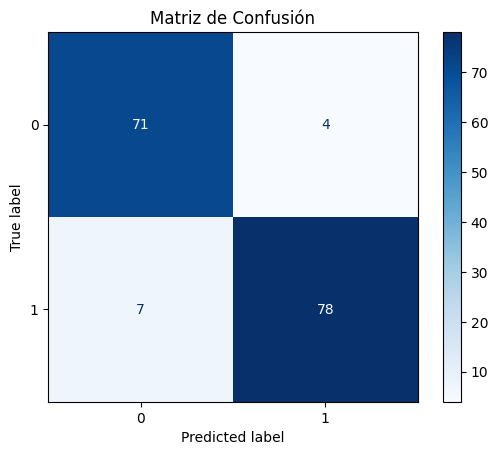

              precision    recall  f1-score   support

           0       0.91      0.95      0.93        75
           1       0.95      0.92      0.93        85

    accuracy                           0.93       160
   macro avg       0.93      0.93      0.93       160
weighted avg       0.93      0.93      0.93       160



In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt  # 👈 ¡Este era el que faltaba!

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

# Mostrar métricas adicionales
print(classification_report(y_test, y_pred))


In [ ]:
# Paso 8: Cargar modelo y preprocesadores guardados para hacer predicciones nuevas
model = joblib.load('phishing_model_xgb.pkl')
imputer = joblib.load('imputer.pkl')
scaler = joblib.load('scaler.pkl')

In [ ]:
# Paso 9: Definir función para detectar phishing en una URL dada
predictions_log = []                                  # Lista para guardar historial de predicciones

def detectar_phishing(url):
    try:
        features = extraer_features_desde_url(url)              # Extraer features de la URL nueva
        features_df = pd.DataFrame([features])                    # Convertir dict a DataFrame
        features_imputadas = imputer.transform(features_df)      # Imputar valores faltantes
        features_escaladas = scaler.transform(features_imputadas)  # Escalar features
        pred = model.predict(features_escaladas)                  # Hacer predicción
        result = "🔴 Phishing" if pred[0] == 1 else "🟢 Benigna"  # Interpretar resultado

        # Guardar la predicción junto con timestamp y URL en el historial
        predictions_log.append({"timestamp": datetime.datetime.now(), "url": url, "prediction": result})

        return result                                             # Retornar resultado al usuario
    except Exception as e:
        return f"⚠️ Error al procesar: {str(e)}"                 # Manejo simple de errores

# Función para mostrar las últimas 20 predicciones del historial
def ver_historial():
    try:
        log_df = pd.DataFrame(predictions_log)                    # Convertir lista a DataFrame
        return log_df.tail(20)                                     # Mostrar solo últimas 20 filas
    except FileNotFoundError:
        # Si no hay historial, retornar DataFrame vacío con columnas definidas
        return pd.DataFrame(columns=["timestamp", "url", "prediction"])

# Función para descargar historial en un archivo CSV temporal
def descargar_historial():
    log_df = pd.DataFrame(predictions_log)                        # Convertir historial a DataFrame
    if not log_df.empty:                                           # Si hay datos en el historial
        log_df.to_csv("/tmp/predictions_log.csv", index=False)    # Guardar CSV temporal
        return "/tmp/predictions_log.csv"                          # Retornar ruta para descarga
    else:
        return None                                                # Si no hay datos, no descargar

In [ ]:
# Paso 10: Crear interfaz gráfica con Gradio
with gr.Blocks() as demo:
    gr.Markdown("# 🛡️ Detector de URLs Phishing con XGBoost")  # Título de la app

    with gr.Tab("🔍 Analizar URL"):                              # Pestaña para análisis de URLs
        url_input = gr.Textbox(label="Introduce una URL")       # Campo para ingresar URL
        output = gr.Textbox(label="Resultado")                   # Campo para mostrar resultado
        btn = gr.Button("Analizar")                              # Botón para disparar análisis
        btn.click(fn=detectar_phishing, inputs=url_input, outputs=output)  # Al hacer click llama a función detectar_phishing

    with gr.Tab("📜 Ver historial"):                             # Pestaña para ver historial
        historial_output = gr.Dataframe(label="Historial de predicciones", interactive=False)  # Tabla para mostrar historial
        actualizar = gr.Button("Actualizar historial")          # Botón para refrescar tabla
        actualizar.click(fn=ver_historial, outputs=historial_output)  # Al click actualizar tabla con función ver_historial

        descargar_btn = gr.Button("Descargar historial como CSV")  # Botón para descargar CSV
        file_output = gr.File()                                  # Componente para mostrar archivo descargable
        descargar_btn.click(fn=descargar_historial, outputs=file_output)  # Al click generar y mostrar archivo

# Lanzar la aplicación web Gradio para que esté disponible en navegador
demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4a5747e2667fcda1be.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
